In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
import pandas as pd

# Define the file path
entities_file_path = '/content/drive/My Drive/booknlp_output/blue_castle_BNLP/tori/TORI_blue_castle.entities'

# Load the file into a pandas DataFrame
entities = pd.read_csv(entities_file_path, delimiter='\t')

# Display the first few rows of the DataFrame
entities.head()


,COREF,start_token,end_token,prop,cat,text
0,325,2,4,NOM,FAC,The Blue Castle
1,80,10,12,PROP,PER,L. M. Montgomery
2,326,37,38,NOM,GPE,United States
3,81,40,43,PROP,PER,Frederick A. Stokes company
4,82,48,50,PROP,PER,Laura Natal Rodrigues


In [68]:
import pandas as pd

# Define the file path
quotes_file_path = '/content/drive/My Drive/booknlp_output/blue_castle_BNLP/tori/TORI_blue_castle.quotes'

# Load the file into a pandas DataFrame
quotes = pd.read_csv(quotes_file_path, delimiter='\t')

# Display the first few rows of the DataFrame
quotes.head()


,quote_start,quote_end,mention_start,mention_end,mention_phrase,char_id,quote
0,434,437,439,439,Valancy,83,"“ Suppose , ”"
1,445,486,439,439,Valancy,83,"“ I answered with the plain truth , ‘ I am cry..."
2,496,501,502,502,Valancy,83,"“ It is not , ”"
3,514,521,505,506,her mother,343,“ it is notmaidenlyto think aboutmen . ”
4,635,637,609,609,She,83,“ hooked ”


In [73]:
import pandas as pd
from collections import defaultdict

# List of characters extracted from the document
character_list = [
    "Valancy", "Barney", "Roaring Abel", "Mrs. Frederick", "Cissy",
    "Uncle Benjamin", "Cousin Stickles", "Dr. Trent", "Olive", "Uncle James"]

# Convert the mention phrases and character list to lower case for consistent matching
quotes['mention_phrase'] = quotes['mention_phrase'].str.lower()
character_list = [name.lower() for name in character_list]

# Filter quotes to only include mentions of characters from the list
filtered_quotes = quotes[quotes['mention_phrase'].isin(character_list)]

# Reset index for easier sequential processing
filtered_quotes = filtered_quotes.reset_index(drop=True)


In [74]:
# Initialize a list to store character interaction pairs
interactions = []

# Define the window for considering co-occurrences
window_size = 5  # This is the number of subsequent mentions to check for interactions

# Loop through the mentions
for i in range(len(filtered_quotes) - 1):
    current_character = filtered_quotes.loc[i, 'mention_phrase']
    for j in range(1, window_size + 1):
        if i + j < len(filtered_quotes):
            next_character = filtered_quotes.loc[i + j, 'mention_phrase']
            if current_character != next_character:
                interactions.append((current_character, next_character))

# Convert interactions to a DataFrame
interaction_df = pd.DataFrame(interactions, columns=['Character1', 'Character2'])

# Display the first few rows to check
print(interaction_df.head())

  Character1       Character2
0    valancy   uncle benjamin
1    valancy   uncle benjamin
2    valancy  cousin stickles
3    valancy   uncle benjamin
4    valancy  cousin stickles


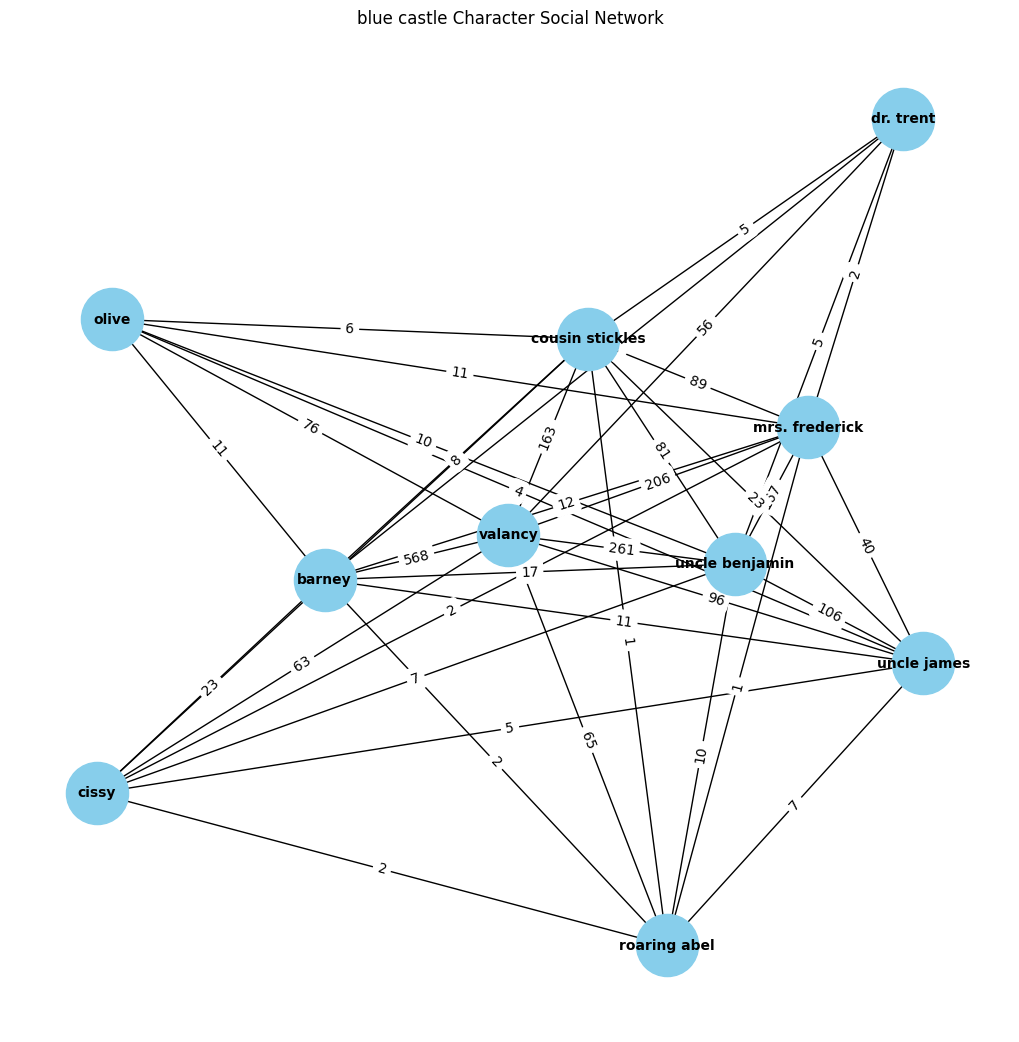

In [75]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Create an adjacency matrix
adjacency_dict = defaultdict(int)

# Count interactions between characters
for _, row in interaction_df.iterrows():
    adjacency_dict[(row['Character1'], row['Character2'])] += 1
    adjacency_dict[(row['Character2'], row['Character1'])] += 1

# Create a DataFrame from the adjacency dictionary
adj_matrix = pd.DataFrame(0, index=character_list, columns=character_list)

for (char1, char2), count in adjacency_dict.items():
    adj_matrix.loc[char1, char2] = count
    adj_matrix.loc[char2, char1] = count

# Visualize the network
G = nx.Graph()

# Add nodes for each character
G.add_nodes_from(character_list)

# Add edges with weights based on the adjacency matrix
for i in range(len(character_list)):
    for j in range(i + 1, len(character_list)):
        if adj_matrix.iloc[i, j] > 0:
            G.add_edge(character_list[i], character_list[j], weight=adj_matrix.iloc[i, j])

# Visualize the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("blue castle Character Social Network")
plt.show()
